![](https://static0.givemesportimages.com/wordpress/wp-content/uploads/2024/01/study-names-the-10-most-expensive-players-in-the-world-image-1.jpg)

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>1 |</span></b> <b>INTRODUCTION</b></div>


### <b><span style='color:#FFCE30'> 1.1 |</span> Objective</b>

Having performed EDA in the EDA.ipynb, we will now use this notebook to make an initial experiment on the models before to convert them into modular code for the end-to-end pipeline. The following points are the insights and actions to take on the dataset that were derived from the EDA.

#### Data Preprocessing

| No. | Action | Reason|
| --- | ------ | ------|
|1| Drop Columns: Unnamed: 64, Name, Team & Contract| Nan Values, or not useful|
|2| Drop duplicated rows | Duplicated rows needds to be removed|
|3| For these variable we need to make the summation or subtraction for some entries and convert to numeric: Overall rating, potential, Crossing, Finishing, Heading accuracy, Short passing, Volleys, Dribbling, Curve, FK Accuracy, Long passing, Ball Control, Acceleration, Sprint speed, Agility, Reactions, Balance, Shot power, Jumping, Stamina, Strength, Long Shots, Aggression, Interceptions, Att. Position, Vision, Penalties, Composure, Defensive awareness, Standing tackle, Sliding tackle', GK Diving, GK Handling, GK Kicking, GK Positioning, GK Reflexes | Convert object to numeric|
|4|  For these features we need to treat: Height (take the interger for cm) , Weight (take the interger for kg), Value (convert from to numeric), Wage (convert to numeric), Release Clause (convert to numeric),| Convert object to numeric |

#### Feature Selection and Other considerations

| No. | Action | Reason|
| --- | ------ | ------|
|1| Perform feature selection based on feature importance, drop columns with high VIF | Many columns with high VIF and multicollinerity | 
|2| Outliers in data | Perform Robust Scaling|

### <b><span style='color:#FFCE30'> 1.2 |</span> Evaluation Metric</b>

For the context of this problem, there are several metrics that can be considered.

1. Mean Absolute Error (MAE): This metric measures the average absolute difference between predicted and actual scores. It provides a straightforward interpretation of the model's prediction errors in the same unit as the target variable (examination scores).
2. Root Mean Squared Error (RMSE): RMSE is similar to MAE but gives higher weight to large errors. It penalizes larger errors more heavily, making it suitable for cases where large errors are particularly undesirable.
3. Mean Squared Error (MSE): MSE is the average of the squared differences between predicted and actual scores. It provides a measure of the average squared error of the model's predictions and is useful for understanding the spread of prediction errors.
4. R-squared (R2) Score: R2 score represents the proportion of the variance in the target variable that is explained by the model. It indicates how well the independent variables explain the variability of the dependent variable. A higher R2 score indicates a better fit of the model to the data.


- RMSE (Root Mean Squared Error) is a suitable metric for predicting football player prices due to several reasons. First, in the context of player prices, where the goal is to accurately estimate the monetary value of a player, RMSE provides a direct measure of the prediction error in the same units as the target variable (i.e., currency). This makes RMSE intuitive and easy to interpret, as it represents the average magnitude of the errors in predicting player prices.

- Second, RMSE considers both the magnitude and direction of errors, making it a comprehensive measure of model performance. By squaring the errors before taking the square root, RMSE penalizes larger errors more heavily than smaller ones. In the context of football player prices, where accurately predicting high-value players may be more critical, RMSE effectively captures the impact of these larger errors on overall model performance.

- Additionally, RMSE is widely used and accepted in regression tasks, making it suitable for comparing different models and assessing their predictive accuracy. Its popularity stems from its simplicity and robustness, as it provides a single, easy-to-understand metric that summarizes the overall performance of a regression model.

- Overall, RMSE serves as a reliable evaluation metric for predicting football player prices, capturing both the accuracy and precision of the model's predictions while allowing for straightforward interpretation and comparison across models.


The formula for RMSE is:
$
{RMSE} = \sqrt{\frac{1}{n} sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$

    


In [1]:
import numpy as np

# Assuming y_true and y_pred are NumPy arrays containing the true and predicted values respectively
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>2 |</span></b> <b>IMPORT LIBRARIES AND DATASET</b></div>

In [50]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 200)

import warnings
warnings.filterwarnings('ignore')

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import OrdinalEncoder
import xgboost as xgb #import model for feature importance analysis

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import make_scorer
from math import sqrt

import optuna
from sklearn.model_selection import StratifiedKFold

import shap

from sklearn.model_selection import train_test_split



In [3]:
df = pd.read_csv("../data/players_17937.csv")
df.head()

,name,Age,Overall rating,Potential,Team & Contract,ID,Height,Weight,foot,Best overall,Best position,Growth,Value,Wage,Release clause,Total attacking,Crossing,Finishing,Heading accuracy,Short passing,Volleys,Total skill,Dribbling,Curve,FK Accuracy,Long passing,Ball control,Total movement,Acceleration,Sprint speed,Agility,Reactions,Balance,Total power,Shot power,Jumping,Stamina,Strength,Long shots,Total mentality,Aggression,Interceptions,Att. Position,Vision,Penalties,Composure,Total defending,Defensive awareness,Standing tackle,Sliding tackle,Total goalkeeping,GK Diving,GK Handling,GK Kicking,GK Positioning,GK Reflexes,Total stats,Base stats,International reputation,Pace / Diving,Shooting / Handling,Passing / Kicking,Dribbling / Reflexes,Defending / Pace,Unnamed: 64
0,15 Ronaldinho CAM ST,34,78,78,Querétaro\n2014 ~ 2016,28130,"182cm / 6'0""",76kg / 168lbs,Right,77,CAM,0,€4.1M,€45K,€0,367,84,69,50,82,82,430,86,86,87,81,90,313,50,48,73,70,72,314,74,55,41,72,72,319,60,25,66,82,86,0,78,25,28,25,54,7,14,13,6,14,1875,377,3,49,72,83,84,28,NaN
1,O. Hutchinson RM CAM,19,65,81,Ipswich Town\n2022 ~ 2025,260145,"174cm / 5'9""",65kg / 143lbs,Left,67,CAM,16,€1.8M,€3K,€4.5M,266,48,53,49,66,50,304,69,52,50,65,68,366,76,69,81,61,79,272,62,56,63,47,44,264,41,37,60,65,61,63,140,40,49,51,39,10,7,9,5,8,1651,351,1,72,54,61,70,44,NaN
2,Brahim CAM,23,82,86,Real Madrid\n2019 ~ 2027,231410,"170cm / 5'7""",68kg / 150lbs,Right,84,CAM,4,€43.5M,€145K,€92.4M,328,75,76,30,83,64,379,84,74,61,75,85,429,85,85,89,79,91,332,73,60,68,55,76,294,44,33,78,81,58,79,84,40,23,21,51,13,9,13,10,6,1897,409,1,85,74,78,85,31,NaN
3,K. Wätjen CM,17,62,80,Borussia Dortmund\n2024 ~ 2028,70728,"178cm / 5'10""",72kg / 159lbs,Right,65,CAM,18,€1M,€900,€2.3M,257,48,53,45,67,44,292,66,52,43,65,66,356,77,68,78,59,74,267,48,58,63,51,47,263,47,54,54,59,49,49,161,50,55,56,48,9,13,7,11,8,1644,353,1,72,50,59,66,52,NaN
4,C. Chaplin CAM,26,74,75,Ipswich Town\n2021 ~ 2026,225667,"168cm / 5'6""",69kg / 152lbs,Left,75,ST,1,€5M,€19K,€9.9M,358,63,79,73,73,70,352,72,72,68,65,75,417,81,83,89,73,91,346,72,75,74,50,75,322,70,40,74,72,66,73,131,50,38,43,65,13,16,10,14,12,1991,409,1,82,75,69,76,46,NaN


# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>3 |</span></b> <b>DATA PREPROCESSING</b></div>

| No. | Action | Reason|
| --- | ------ | ------|
|1| Drop Columns: Unnamed: 64, Name, Team & Contract| Nan Values, or not useful|
|2| Drop duplicated rows | Duplicated rows needds to be removed|
|3| For these variable we need to make the summation or subtraction for some entries and convert to numeric: Overall rating, potential, Crossing, Finishing, Heading accuracy, Short passing, Volleys, Dribbling, Curve, FK Accuracy, Long passing, Ball Control, Acceleration, Sprint speed, Agility, Reactions, Balance, Shot power, Jumping, Stamina, Strength, Long Shots, Aggression, Interceptions, Att. Position, Vision, Penalties, Composure, Defensive awareness, Standing tackle, Sliding tackle', GK Diving, GK Handling, GK Kicking, GK Positioning, GK Reflexes | Convert object to numeric|
|4|  For these features we need to treat: Height (take the interger for cm) , Weight (take the interger for kg), Value (convert from to numeric), Wage (convert to numeric), Release Clause (convert to numeric),| Convert object to numeric |

### Set Index

In [4]:
# Set 'ID' column as the index
df.set_index('ID', inplace=True)

### Drop Columns

In [5]:
# Drop specified columns
columns_to_drop = ['Unnamed: 64', 'name', 'Team & Contract']
df = df.drop(columns=columns_to_drop)

### Drop Duplicated Rows (index)

In [6]:
df = df.loc[~df.index.duplicated()].copy()

### Summation and Subtraction to Numeric

In [7]:
# Define a function to handle values in the format 'number+number'
def handle_plus_minus(value):
    if isinstance(value, str) and '+' in value:
        parts = value.split('+')
        return int(parts[0]) + int(parts[1])
    elif isinstance(value, str) and '-' in value:
        parts = value.split('-')
        return int(parts[0]) - int(parts[1])
    else:
        return value

# Define the list of variables to convert to numeric and perform operations
numeric_variables = ['Overall rating', 'Potential', 'Crossing', 'Finishing', 'Heading accuracy', 'Short passing', 
                     'Volleys', 'Dribbling', 'Curve', 'FK Accuracy', 'Long passing', 'Ball control', 
                     'Acceleration', 'Sprint speed', 'Agility', 'Reactions', 'Balance', 'Shot power', 
                     'Jumping', 'Stamina', 'Strength', 'Long shots', 'Aggression', 'Interceptions', 
                     'Att. Position', 'Vision', 'Penalties', 'Composure', 'Defensive awareness', 
                     'Standing tackle', 'Sliding tackle', 'GK Diving', 'GK Handling', 'GK Kicking', 
                     'GK Positioning', 'GK Reflexes']

# Apply the custom function to handle values in the specified columns
df[numeric_variables] = df[numeric_variables].applymap(handle_plus_minus)
df[numeric_variables] = df[numeric_variables].apply(pd.to_numeric, errors='coerce')

### Convert Height, Weight, Value, Wage and Release Clause

In [8]:
# Define a function to extract height in cm
def extract_height(height):
    if isinstance(height, str):
        # Split the string by '/'
        parts = height.split('/')
        # Extract the part with cm
        cm_part = parts[0].strip()
        # Extract the integer value for cm
        height_cm = int(cm_part.replace('cm', '').strip())
        return height_cm
    else:
        return height

# Define a function to extract weight in kg
def extract_weight(weight):
    if isinstance(weight, str):
        # Split the string by '/'
        parts = weight.split('/')
        # Extract the part with kg
        kg_part = parts[0].strip()
        # Extract the integer value for kg
        weight_kg = int(kg_part.replace('kg', '').strip())
        return weight_kg
    else:
        return weight

# Apply the custom functions to extract height and weight
df['Height'] = df['Height'].apply(extract_height)
df['Weight'] = df['Weight'].apply(extract_weight)

In [17]:
# Define a function to convert value strings to numeric
def convert_value(value):
    if isinstance(value, str):
        if value[-1] == 'M':
            return float(value[1:-1].replace('M', '')) * 1000
        elif value[-1] == 'K':
            return float(value[1:-1].replace('K', '')) 
        else:
            return float(value[1:])
    else:
        return value

# Define a function to convert wage strings to numeric
def convert_wage(wage):
    if isinstance(wage, str):
        if wage[-1] == 'K':
            return float(wage[1:-1].replace('K', '')) 
        else:
            return float(wage[1:])
    else:
        return wage

# Define a function to convert release clause strings to numeric
def convert_release_clause(release_clause):
    if isinstance(release_clause, str):
        if release_clause[-1] == 'M':
            return float(release_clause[1:-1].replace('M', '')) * 1000
        elif release_clause[-1] == 'K':
            return float(release_clause[1:-1].replace('K', '')) 
        else:
            return float(release_clause[1:])
    else:
        return release_clause

# Apply the custom functions to convert value, wage, and release clause
df["Value('000)"] = df['Value'].apply(convert_value)
df["Wage('000)"] = df['Wage'].apply(convert_wage)
df["Release clause('000)"] = df['Release clause'].apply(convert_release_clause)


# Drop the specified columns
df = df.drop(columns=['Value', 'Wage', 'Release clause'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16013 entries, 28130 to 262942
Data columns (total 61 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       16013 non-null  int64 
 1   Overall rating            16013 non-null  int64 
 2   Potential                 16013 non-null  int64 
 3   Height                    16013 non-null  int64 
 4   Weight                    16013 non-null  int64 
 5   foot                      16013 non-null  object
 6   Best overall              16013 non-null  int64 
 7   Best position             16013 non-null  object
 8   Growth                    16013 non-null  int64 
 9   Value                     16013 non-null  object
 10  Wage                      16013 non-null  object
 11  Release clause            16013 non-null  object
 12  Total attacking           16013 non-null  int64 
 13  Crossing                  16013 non-null  int64 
 14  Finishing             

In [10]:
df.head()

,Age,Overall rating,Potential,Height,Weight,foot,Best overall,Best position,Growth,Value,Wage,Release clause,Total attacking,Crossing,Finishing,Heading accuracy,Short passing,Volleys,Total skill,Dribbling,Curve,FK Accuracy,Long passing,Ball control,Total movement,Acceleration,Sprint speed,Agility,Reactions,Balance,Total power,Shot power,Jumping,Stamina,Strength,Long shots,Total mentality,Aggression,Interceptions,Att. Position,Vision,Penalties,Composure,Total defending,Defensive awareness,Standing tackle,Sliding tackle,Total goalkeeping,GK Diving,GK Handling,GK Kicking,GK Positioning,GK Reflexes,Total stats,Base stats,International reputation,Pace / Diving,Shooting / Handling,Passing / Kicking,Dribbling / Reflexes,Defending / Pace
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
28130,34,78,78,182,76,Right,77,CAM,0,€4.1M,€45K,€0,367,84,69,50,82,82,430,86,86,87,81,90,313,50,48,73,70,72,314,74,55,41,72,72,319,60,25,66,82,86,0,78,25,28,25,54,7,14,13,6,14,1875,377,3,49,72,83,84,28
260145,19,65,81,174,65,Left,67,CAM,16,€1.8M,€3K,€4.5M,266,48,53,49,66,50,304,69,52,50,65,68,366,76,69,81,61,79,272,62,56,63,47,44,264,41,37,60,65,61,63,140,40,49,51,39,10,7,9,5,8,1651,351,1,72,54,61,70,44
231410,23,82,86,170,68,Right,84,CAM,4,€43.5M,€145K,€92.4M,328,75,76,30,83,64,379,84,74,61,75,85,429,85,85,89,79,91,332,73,60,68,55,76,294,44,33,78,81,58,79,84,40,23,21,51,13,9,13,10,6,1897,409,1,85,74,78,85,31
70728,17,62,80,178,72,Right,65,CAM,18,€1M,€900,€2.3M,257,48,53,45,67,44,292,66,52,43,65,66,356,77,68,78,59,74,267,48,58,63,51,47,263,47,54,54,59,49,49,161,50,55,56,48,9,13,7,11,8,1644,353,1,72,50,59,66,52
225667,26,74,75,168,69,Left,75,ST,1,€5M,€19K,€9.9M,358,63,79,73,73,70,352,72,72,68,65,75,417,81,83,89,73,91,346,72,75,74,50,75,322,70,40,74,72,66,73,131,50,38,43,65,13,16,10,14,12,1991,409,1,82,75,69,76,46


# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>4 |</span></b> <b>FEATURE ENGINEERING</b></div>

None added

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>5 |</span></b> <b>MODELLING PIPELINE</b></div>


### Drop Columns

In [11]:
class DropColumn(BaseEstimator, TransformerMixin):
    def __init__(self, cols=[]):
        self.cols = cols
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):

        return X.drop(self.cols, axis=1)

DropColumn(cols=['Age']).fit_transform(df)

,Overall rating,Potential,Height,Weight,foot,Best overall,Best position,Growth,Value,Wage,Release clause,Total attacking,Crossing,Finishing,Heading accuracy,Short passing,Volleys,Total skill,Dribbling,Curve,FK Accuracy,Long passing,Ball control,Total movement,Acceleration,Sprint speed,Agility,Reactions,Balance,Total power,Shot power,Jumping,Stamina,Strength,Long shots,Total mentality,Aggression,Interceptions,Att. Position,Vision,Penalties,Composure,Total defending,Defensive awareness,Standing tackle,Sliding tackle,Total goalkeeping,GK Diving,GK Handling,GK Kicking,GK Positioning,GK Reflexes,Total stats,Base stats,International reputation,Pace / Diving,Shooting / Handling,Passing / Kicking,Dribbling / Reflexes,Defending / Pace
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
28130,78,78,182,76,Right,77,CAM,0,€4.1M,€45K,€0,367,84,69,50,82,82,430,86,86,87,81,90,313,50,48,73,70,72,314,74,55,41,72,72,319,60,25,66,82,86,0,78,25,28,25,54,7,14,13,6,14,1875,377,3,49,72,83,84,28
260145,65,81,174,65,Left,67,CAM,16,€1.8M,€3K,€4.5M,266,48,53,49,66,50,304,69,52,50,65,68,366,76,69,81,61,79,272,62,56,63,47,44,264,41,37,60,65,61,63,140,40,49,51,39,10,7,9,5,8,1651,351,1,72,54,61,70,44
231410,82,86,170,68,Right,84,CAM,4,€43.5M,€145K,€92.4M,328,75,76,30,83,64,379,84,74,61,75,85,429,85,85,89,79,91,332,73,60,68,55,76,294,44,33,78,81,58,79,84,40,23,21,51,13,9,13,10,6,1897,409,1,85,74,78,85,31
70728,62,80,178,72,Right,65,CAM,18,€1M,€900,€2.3M,257,48,53,45,67,44,292,66,52,43,65,66,356,77,68,78,59,74,267,48,58,63,51,47,263,47,54,54,59,49,49,161,50,55,56,48,9,13,7,11,8,1644,353,1,72,50,59,66,52
225667,74,75,168,69,Left,75,ST,1,€5M,€19K,€9.9M,358,63,79,73,73,70,352,72,72,68,65,75,417,81,83,89,73,91,346,72,75,74,50,75,322,70,40,74,72,66,73,131,50,38,43,65,13,16,10,14,12,1991,409,1,82,75,69,76,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262935,64,73,182,80,Left,66,CDM,9,€1.1M,€2K,€1.9M,283,51,55,62,72,47,276,60,48,43,69,62,316,59,67,61,56,72,318,63,60,69,62,61,316,74,64,64,63,55,57,187,63,70,60,53,7,8,13,12,13,1749,372,1,65,57,61,59,63
262936,58,68,178,68,Right,60,CAM,10,€425K,€950,€765K,238,40,53,41,62,42,273,64,50,47,51,61,318,63,65,66,52,72,247,56,52,46,45,48,229,45,25,49,60,50,61,111,42,31,38,47,6,12,9,11,9,1463,314,1,64,52,54,63,35
262939,60,73,190,80,Right,60,GK,13,€525K,€2K,€1.1M,58,11,7,14,21,5,79,13,11,11,28,16,164,26,25,28,60,25,194,41,55,27,64,7,91,20,14,12,33,12,31,35,12,12,11,293,60,57,55,56,65,914,319,1,60,57,55,65,26


### Robust Scaler

In [12]:
# Using Robust Scaler to scale numeric variables

class RobustScalerNamed(RobustScaler, TransformerMixin):
    def get_feature_names_out(self, X, y=None):
        return X.columns.tolist()

    def transform(self, X, y=None):
        transformed = super().transform(X, y)
        return pd.DataFrame(transformed, columns=X.columns)

### Define Numerical and Categorical Columns

In [26]:
# define numerical & categorical columns
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']

# Define all features
all_features = df.columns.tolist()

### Setup Pipeline

In [14]:
named_preprocessing_pipeline = Pipeline([
    
    ('drop', DropColumn(cols=[])),
    ('prep', ColumnTransformer([
        ('encode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
         list(set(categorical_features)
              )),],
        remainder='passthrough').set_output(transform='pandas')),

    ('scale',RobustScaler().set_output(transform='pandas'))

   
])

named_preprocessing_pipeline

Pipeline(steps=[('drop', DropColumn()),
                ('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encode',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Wage', 'Best position',
                                                   'foot', 'Release clause',
                                                   'Value'])])),
                ('scale', RobustScaler())])

In [15]:
#checking output on df dataframe
df_train = named_preprocessing_pipeline.fit_transform(df)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16013 entries, 28130 to 262942
Data columns (total 61 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   encode__Wage                         16013 non-null  float64
 1   encode__Best position                16013 non-null  float64
 2   encode__foot                         16013 non-null  float64
 3   encode__Release clause               16013 non-null  float64
 4   encode__Value                        16013 non-null  float64
 5   remainder__Age                       16013 non-null  float64
 6   remainder__Overall rating            16013 non-null  float64
 7   remainder__Potential                 16013 non-null  float64
 8   remainder__Height                    16013 non-null  float64
 9   remainder__Weight                    16013 non-null  float64
 10  remainder__Best overall              16013 non-null  float64
 11  remainder__Growth           

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>6 |</span></b> <b>MODEL TRAINING</b></div>


In [18]:
X = df.drop(["Value('000)"], axis=1)
y = df["Value('000)"]

In [25]:
X.head()

,Age,Overall rating,Potential,Height,Weight,foot,Best overall,Best position,Growth,Total attacking,Crossing,Finishing,Heading accuracy,Short passing,Volleys,Total skill,Dribbling,Curve,FK Accuracy,Long passing,Ball control,Total movement,Acceleration,Sprint speed,Agility,Reactions,Balance,Total power,Shot power,Jumping,Stamina,Strength,Long shots,Total mentality,Aggression,Interceptions,Att. Position,Vision,Penalties,Composure,Total defending,Defensive awareness,Standing tackle,Sliding tackle,Total goalkeeping,GK Diving,GK Handling,GK Kicking,GK Positioning,GK Reflexes,Total stats,Base stats,International reputation,Pace / Diving,Shooting / Handling,Passing / Kicking,Dribbling / Reflexes,Defending / Pace,Wage('000),Release clause('000)
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
28130,34,78,78,182,76,Right,77,CAM,0,367,84,69,50,82,82,430,86,86,87,81,90,313,50,48,73,70,72,314,74,55,41,72,72,319,60,25,66,82,86,0,78,25,28,25,54,7,14,13,6,14,1875,377,3,49,72,83,84,28,45.0,0.0
260145,19,65,81,174,65,Left,67,CAM,16,266,48,53,49,66,50,304,69,52,50,65,68,366,76,69,81,61,79,272,62,56,63,47,44,264,41,37,60,65,61,63,140,40,49,51,39,10,7,9,5,8,1651,351,1,72,54,61,70,44,3.0,4500.0
231410,23,82,86,170,68,Right,84,CAM,4,328,75,76,30,83,64,379,84,74,61,75,85,429,85,85,89,79,91,332,73,60,68,55,76,294,44,33,78,81,58,79,84,40,23,21,51,13,9,13,10,6,1897,409,1,85,74,78,85,31,145.0,92400.0
70728,17,62,80,178,72,Right,65,CAM,18,257,48,53,45,67,44,292,66,52,43,65,66,356,77,68,78,59,74,267,48,58,63,51,47,263,47,54,54,59,49,49,161,50,55,56,48,9,13,7,11,8,1644,353,1,72,50,59,66,52,900.0,2300.0
225667,26,74,75,168,69,Left,75,ST,1,358,63,79,73,73,70,352,72,72,68,65,75,417,81,83,89,73,91,346,72,75,74,50,75,322,70,40,74,72,66,73,131,50,38,43,65,13,16,10,14,12,1991,409,1,82,75,69,76,46,19.0,9900.0


### Pipeline 1: Include all features

In [28]:
# Define models
models = [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    XGBRegressor(),
    LGBMRegressor(verbosity = -1),
    CatBoostRegressor(verbose=0)
]

# Define cross-validation parameters
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Iterate over models
for model in models:
    # Print model name
    print("Model:", model.__class__.__name__)
    
    # Define RMSE scorer
    rmse_scorer = make_scorer(rmse, greater_is_better=False)
    
    # Define pipeline with model
    pipeline = Pipeline([
        ('preprocessor', named_preprocessing_pipeline),
        ('model', model)
    ])
    
    # Perform cross-validation
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring=rmse_scorer)
    
    # Print mean RMSE score
    print("Mean RMSE:", -scores.mean())
    print("-------------------------------------")

Model: LinearRegression
Mean RMSE: 1743.6097037150146
-------------------------------------
Model: DecisionTreeRegressor
Mean RMSE: 1478.4386456697987
-------------------------------------
Model: RandomForestRegressor
Mean RMSE: 1018.4165066817708
-------------------------------------
Model: XGBRegressor
Mean RMSE: 1025.430956012931
-------------------------------------
Model: LGBMRegressor
Mean RMSE: 1217.316587258805
-------------------------------------
Model: CatBoostRegressor
Mean RMSE: 940.9923184211493
-------------------------------------


### Pipeline 2: Drop features based on feature importance, SHAP Analysis, VIF, and other considerations

We will drop all other features except those listed here

- **Top 10 Feature importance:** Release Clause ('000), Best overall, Potential, Overall rating, Wage ('000), Age, Finishing, Composure, Total movement, Sprint speed
- **Additional from SHAP Analysis:** None
- **VIF < 5 :** International reputation
- **To predict for goalkeepers:** GK Kicking, GK Positioning, GK Handling, GK Reflexes, GK Diving
- **Categorical to keep:** foot, Best position

In order to have the model to predict for goalkeepers we need to keep some features that are useful only for goalkeepers.


In [30]:
# List all columns
all_columns = df.columns.tolist()

# Specify columns to keep
columns_to_keep = ["Release Clause('000)", 'Best overall', 'Potential', 'Overall rating', "Wage('000)", 'Age', 'Finishing', 'Composure', 'Total movement', 'Sprint speed', 
                   'International reputation', 
                   'GK Kicking', 'GK Positioning', 'GK Handling', 'GK Reflexes', 'GK Diving', 
                   'foot', 
                   'Best position']

# Remove specified columns from the list of all columns
columns_to_drop = [col for col in all_columns if col not in columns_to_keep]

columns_to_drop

['Height',
 'Weight',
 'Growth',
 'Total attacking',
 'Crossing',
 'Heading accuracy',
 'Short passing',
 'Volleys',
 'Total skill',
 'Dribbling',
 'Curve',
 'FK Accuracy',
 'Long passing',
 'Ball control',
 'Acceleration',
 'Agility',
 'Reactions',
 'Balance',
 'Total power',
 'Shot power',
 'Jumping',
 'Stamina',
 'Strength',
 'Long shots',
 'Total mentality',
 'Aggression',
 'Interceptions',
 'Att. Position',
 'Vision',
 'Penalties',
 'Total defending',
 'Defensive awareness',
 'Standing tackle',
 'Sliding tackle',
 'Total goalkeeping',
 'Total stats',
 'Base stats',
 'Pace / Diving',
 'Shooting / Handling',
 'Passing / Kicking',
 'Dribbling / Reflexes',
 'Defending / Pace',
 "Value('000)",
 "Wage('000)",
 "Release clause('000)"]

In [31]:
pipeline_2 = Pipeline([
    
    ('drop', DropColumn(cols=['Height', 'Weight', 'Growth', 'Total attacking', 'Crossing', 'Heading accuracy', 'Short passing', 'Volleys', 'Total skill', 'Dribbling', 'Curve', 'FK Accuracy',
                              'Long passing', 'Ball control', 'Acceleration', 'Agility', 'Reactions', 'Balance', 'Total power', 'Shot power', 'Jumping', 'Stamina', 'Strength', 'Long shots',
                              'Total mentality', 'Aggression', 'Interceptions', 'Att. Position', 'Vision', 'Penalties', 'Total defending', 'Defensive awareness', 'Standing tackle', 
                              'Sliding tackle', 'Total goalkeeping', 'Total stats', 'Base stats', 'Pace / Diving', 'Shooting / Handling', 'Passing / Kicking', 'Dribbling / Reflexes', 
                              'Defending / Pace']
                       )),

    ('prep', ColumnTransformer([
        ('encode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
         list(set(categorical_features)
              -set([
                            'Height', 'Weight', 'Growth', 'Total attacking', 'Crossing', 'Heading accuracy', 'Short passing', 'Volleys', 'Total skill', 'Dribbling', 'Curve', 'FK Accuracy',
                              'Long passing', 'Ball control', 'Acceleration', 'Agility', 'Reactions', 'Balance', 'Total power', 'Shot power', 'Jumping', 'Stamina', 'Strength', 'Long shots',
                              'Total mentality', 'Aggression', 'Interceptions', 'Att. Position', 'Vision', 'Penalties', 'Total defending', 'Defensive awareness', 'Standing tackle', 
                              'Sliding tackle', 'Total goalkeeping', 'Total stats', 'Base stats', 'Pace / Diving', 'Shooting / Handling', 'Passing / Kicking', 'Dribbling / Reflexes', 
                              'Defending / Pace'                  
                  ])
              )),],
        remainder='passthrough').set_output(transform='pandas')),

    ('scale',RobustScaler().set_output(transform='pandas'))

   
])

pipeline_2

Pipeline(steps=[('drop',
                 DropColumn(cols=['Height', 'Weight', 'Growth',
                                  'Total attacking', 'Crossing',
                                  'Heading accuracy', 'Short passing',
                                  'Volleys', 'Total skill', 'Dribbling',
                                  'Curve', 'FK Accuracy', 'Long passing',
                                  'Ball control', 'Acceleration', 'Agility',
                                  'Reactions', 'Balance', 'Total power',
                                  'Shot power', 'Jumping', 'Stamina',
                                  'Strength', 'Long shots', 'Total mentality',
                                  'Aggression', 'Interceptions',
                                  'Att. Position', 'Vision', 'Penalties', ...])),
                ('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encode',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['foot', 'Best position'])])),
                ('scale', RobustScaler())])

In [32]:
# Define models
models = [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    XGBRegressor(),
    LGBMRegressor(verbosity = -1),
    CatBoostRegressor(verbose=0)
]

# Define cross-validation parameters
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Iterate over models
for model in models:
    # Print model name
    print("Model:", model.__class__.__name__)
    
    # Define RMSE scorer
    rmse_scorer = make_scorer(rmse, greater_is_better=False)
    
    # Define pipeline with model
    pipeline = Pipeline([
        ('preprocessor', pipeline_2),
        ('model', model)
    ])
    
    # Perform cross-validation
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring=rmse_scorer)
    
    # Print mean RMSE score
    print("Mean RMSE:", -scores.mean())
    print("-------------------------------------")

Model: LinearRegression
Mean RMSE: 1757.1286451624117
-------------------------------------
Model: DecisionTreeRegressor
Mean RMSE: 1229.8168874635357
-------------------------------------
Model: RandomForestRegressor
Mean RMSE: 938.6573862973428
-------------------------------------
Model: XGBRegressor
Mean RMSE: 1029.2333380481216
-------------------------------------
Model: LGBMRegressor
Mean RMSE: 1168.0658374802656
-------------------------------------
Model: CatBoostRegressor
Mean RMSE: 824.5979726367874
-------------------------------------


<font color='DarkOrange'>

#### **Insights**
1. Pipeline 2 where we had dropped many features turns out to be better with generally lower RMSE scores
2. Best one so far is CatBoost Regressor with RMSE of 824 KEUR

### Pipeline 3: Drop features as per Pipeline 2 but keep only 12 best features

We will drop all other features except those listed here

- **Top 10 Feature importance:** Release Clause ('000), Best overall, Potential, Overall rating, Wage ('000), Age, Finishing, Composure, Total movement, Sprint speed
- **Additional from SHAP Analysis:** None
- **VIF < 5 :** International reputation
- **To predict for goalkeepers:** None
- **Categorical to keep:** Best position

In order to have the model to predict for goalkeepers we need to keep some features that are useful only for goalkeepers.


In [22]:
# List all columns
all_columns = df.columns.tolist()

# Specify columns to keep
columns_to_keep = ["Release clause('000)", 'Best overall', 'Potential', 'Overall rating', "Wage('000)", 'Age', 'Finishing', 'Composure', 'Total movement', 'Sprint speed', 
                   'International reputation', 
                #    'GK Kicking', 'GK Positioning', 'GK Handling', 'GK Reflexes', 'GK Diving', 
                #    'foot', 
                   'Best position']

# Remove specified columns from the list of all columns
columns_to_drop = [col for col in all_columns if col not in columns_to_keep]

columns_to_drop

['Height',
 'Weight',
 'foot',
 'Growth',
 'Total attacking',
 'Crossing',
 'Heading accuracy',
 'Short passing',
 'Volleys',
 'Total skill',
 'Dribbling',
 'Curve',
 'FK Accuracy',
 'Long passing',
 'Ball control',
 'Acceleration',
 'Agility',
 'Reactions',
 'Balance',
 'Total power',
 'Shot power',
 'Jumping',
 'Stamina',
 'Strength',
 'Long shots',
 'Total mentality',
 'Aggression',
 'Interceptions',
 'Att. Position',
 'Vision',
 'Penalties',
 'Total defending',
 'Defensive awareness',
 'Standing tackle',
 'Sliding tackle',
 'Total goalkeeping',
 'GK Diving',
 'GK Handling',
 'GK Kicking',
 'GK Positioning',
 'GK Reflexes',
 'Total stats',
 'Base stats',
 'Pace / Diving',
 'Shooting / Handling',
 'Passing / Kicking',
 'Dribbling / Reflexes',
 'Defending / Pace',
 "Value('000)"]

In [45]:
pipeline_3 = Pipeline([
    
    ('drop', DropColumn(cols=['Height', 'Weight', 'Growth', 'Total attacking', 'Crossing', 'Heading accuracy', 'Short passing', 'Volleys', 'Total skill', 'Dribbling', 'Curve', 'FK Accuracy',
                              'Long passing', 'Ball control', 'Acceleration', 'Agility', 'Reactions', 'Balance', 'Total power', 'Shot power', 'Jumping', 'Stamina', 'Strength', 'Long shots',
                              'Total mentality', 'Aggression', 'Interceptions', 'Att. Position', 'Vision', 'Penalties', 'Total defending', 'Defensive awareness', 'Standing tackle', 
                              'Sliding tackle', 'Total goalkeeping', 'Total stats', 'Base stats', 'Pace / Diving', 'Shooting / Handling', 'Passing / Kicking', 'Dribbling / Reflexes', 
                              'Defending / Pace',
                              'GK Kicking', 'GK Positioning', 'GK Handling', 'GK Reflexes', 'GK Diving','foot'

                              ]
                       )),

    ('prep', ColumnTransformer([
        ('encode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
         list(set(categorical_features)
              -set(['foot'
                                             
                  ])
              )),],
        remainder='passthrough').set_output(transform='pandas')),

    ('scale',RobustScaler().set_output(transform='pandas'))

   
])

pipeline_3

Pipeline(steps=[('drop',
                 DropColumn(cols=['Height', 'Weight', 'Growth',
                                  'Total attacking', 'Crossing',
                                  'Heading accuracy', 'Short passing',
                                  'Volleys', 'Total skill', 'Dribbling',
                                  'Curve', 'FK Accuracy', 'Long passing',
                                  'Ball control', 'Acceleration', 'Agility',
                                  'Reactions', 'Balance', 'Total power',
                                  'Shot power', 'Jumping', 'Stamina',
                                  'Strength', 'Long shots', 'Total mentality',
                                  'Aggression', 'Interceptions',
                                  'Att. Position', 'Vision', 'Penalties', ...])),
                ('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encode',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Best position'])])),
                ('scale', RobustScaler())])

In [47]:
# Define models
models = [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    XGBRegressor(),
    LGBMRegressor(verbosity = -1),
    CatBoostRegressor(verbose=0)
]

# Define cross-validation parameters
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Iterate over models
for model in models:
    # Print model name
    print("Model:", model.__class__.__name__)
    
    # Define RMSE scorer
    rmse_scorer = make_scorer(rmse, greater_is_better=False)
    
    # Define pipeline with model
    pipeline = Pipeline([
        ('preprocessor', pipeline_3),
        ('model', model)
    ])
    
    # Perform cross-validation
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring=rmse_scorer)
    
    # Print mean RMSE score
    print("Mean RMSE:", -scores.mean())
    print("-------------------------------------")

Model: LinearRegression
Mean RMSE: 1757.5917754480547
-------------------------------------
Model: DecisionTreeRegressor
Mean RMSE: 1143.303117443688
-------------------------------------
Model: RandomForestRegressor
Mean RMSE: 892.9811435703717
-------------------------------------
Model: XGBRegressor
Mean RMSE: 991.6037073265888
-------------------------------------
Model: LGBMRegressor
Mean RMSE: 1150.7949510528574
-------------------------------------
Model: CatBoostRegressor
Mean RMSE: 840.9728863455657
-------------------------------------


<font color='DarkOrange'>

#### **Insights**
1. Pipeline 3 where we had only retained the top 12 features without GK features turns out to have goot result as well.
2. Best one from this pipeline so far is CatBoost Regressor with RMSE of 840 KEUR

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>7 |</span></b> <b>HYPERPARAMETER TUNING</b></div>


### Hyperparameter Tuning for Catboost with Pipeline 2

In [39]:
# Define objective function for Optuna
def objective(trial):
    # Define hyperparameters to tune
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.001, 10.0),
        'random_strength': trial.suggest_loguniform('random_strength', 0.001, 10.0),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 10.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
    }
    
    # Initialize cross-validation with stratified k-fold
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    
    # Initialize lists to store RMSE scores
    rmse_scores = []
    
    # Perform cross-validation
    for train_index, val_index in kfold.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        # Initialize CatBoostRegressor with current hyperparameters
        CB_model = CatBoostRegressor(**params, verbose=0)

        # Define pipeline with model
        CB_pipeline = Pipeline([
            ('preprocessor', pipeline_2),
            ('model', CB_model)])
        
        # Fit the model
        CB_pipeline.fit(X_train, y_train)
        
        # Make predictions on validation set
        y_pred = CB_pipeline.predict(X_val)
        
        # Calculate RMSE using custom rmse function
        rmse_score = rmse(y_val, y_pred)
        
        # Append RMSE score to list
        rmse_scores.append(rmse_score)
    
    # Return average RMSE score across all folds
    return np.mean(rmse_scores)


In [40]:
# Define study object and optimize hyperparameters
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Get best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2024-05-05 22:34:24,098] A new study created in memory with name: no-name-5dc852b3-338b-48d3-bc4c-ed6849381480
[I 2024-05-05 22:34:53,798] Trial 0 finished with value: 1082.900978816193 and parameters: {'learning_rate': 0.029102386402404486, 'depth': 7, 'l2_leaf_reg': 9.104805243466906, 'random_strength': 0.15493009275873176, 'bagging_temperature': 1.6603965895401098, 'border_count': 145}. Best is trial 0 with value: 1082.900978816193.
[I 2024-05-05 22:36:09,408] Trial 1 finished with value: 980.5582618046434 and parameters: {'learning_rate': 0.02935918351631782, 'depth': 9, 'l2_leaf_reg': 0.09315546729022439, 'random_strength': 1.6961671916685117, 'bagging_temperature': 9.773311606568273, 'border_count': 217}. Best is trial 1 with value: 980.5582618046434.
[I 2024-05-05 22:36:33,869] Trial 2 finished with value: 865.2752292451893 and parameters: {'learning_rate': 0.05012959368173061, 'depth': 5, 'l2_leaf_reg': 0.014340942321171009, 'random_strength': 0.0021135649795046953, 'bagging

Best hyperparameters: {'learning_rate': 0.08121428027066953, 'depth': 5, 'l2_leaf_reg': 0.04706403476478303, 'random_strength': 4.069177853785844, 'bagging_temperature': 0.4872013655862446, 'border_count': 162}


- Best hyperparameters: {'learning_rate': 0.08121428027066953, 'depth': 5, 'l2_leaf_reg': 0.04706403476478303, 'random_strength': 4.069177853785844, 'bagging_temperature': 0.4872013655862446, 'border_count': 162}
- Best is trial 71 with value: 816.9040787753312.

### Hyperparameter Tuning for Catboost with Pipeline 3

In [48]:
# Define objective function for Optuna
def objective(trial):
    # Define hyperparameters to tune
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.001, 10.0),
        'random_strength': trial.suggest_loguniform('random_strength', 0.001, 10.0),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 10.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
    }
    
    # Initialize cross-validation with stratified k-fold
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    
    # Initialize lists to store RMSE scores
    rmse_scores = []
    
    # Perform cross-validation
    for train_index, val_index in kfold.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        # Initialize CatBoostRegressor with current hyperparameters
        CB_model = CatBoostRegressor(**params, verbose=0)

        # Define pipeline with model
        CB_pipeline = Pipeline([
            ('preprocessor', pipeline_3),
            ('model', CB_model)])
        
        # Fit the model
        CB_pipeline.fit(X_train, y_train)
        
        # Make predictions on validation set
        y_pred = CB_pipeline.predict(X_val)
        
        # Calculate RMSE using custom rmse function
        rmse_score = rmse(y_val, y_pred)
        
        # Append RMSE score to list
        rmse_scores.append(rmse_score)
    
    # Return average RMSE score across all folds
    return np.mean(rmse_scores)


In [49]:
# Define study object and optimize hyperparameters
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Get best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2024-05-06 22:21:13,309] A new study created in memory with name: no-name-ebbcdd93-85d1-4412-9e76-3c6bf224a474
[I 2024-05-06 22:21:34,532] Trial 0 finished with value: 977.5277293182598 and parameters: {'learning_rate': 0.009585795428358593, 'depth': 5, 'l2_leaf_reg': 0.012009460913674509, 'random_strength': 0.024596492122797665, 'bagging_temperature': 0.5412141167590769, 'border_count': 85}. Best is trial 0 with value: 977.5277293182598.
[I 2024-05-06 22:22:02,950] Trial 1 finished with value: 994.6267356856437 and parameters: {'learning_rate': 0.03770507395700849, 'depth': 7, 'l2_leaf_reg': 5.776465520098002, 'random_strength': 2.794624868591535, 'bagging_temperature': 0.05638576404641434, 'border_count': 118}. Best is trial 0 with value: 977.5277293182598.
[I 2024-05-06 22:22:54,606] Trial 2 finished with value: 1538.6301149484862 and parameters: {'learning_rate': 0.004489286971618696, 'depth': 9, 'l2_leaf_reg': 8.74099498223914, 'random_strength': 0.012618912996525388, 'bagging_

Best hyperparameters: {'learning_rate': 0.08053070233298747, 'depth': 7, 'l2_leaf_reg': 0.23317891969760632, 'random_strength': 0.0020406061464768484, 'bagging_temperature': 0.6851666420138934, 'border_count': 233}


- Best hyperparameters: {'learning_rate': 0.08053070233298747, 'depth': 7, 'l2_leaf_reg': 0.23317891969760632, 'random_strength': 0.0020406061464768484, 'bagging_temperature': 0.6851666420138934, 'border_count': 233}
- Best is trial 82 with value: 807.7710829832083.

### Visualising the predictions by model versus Actual Value using test set

In [54]:
# Data already split into features (X) and target (y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train CatBoost model
model = CatBoostRegressor(**best_params, verbose = 0)

# Define pipeline with model
CB_pipeline = Pipeline([
            ('preprocessor', pipeline_3),
            ('model', model)])

CB_pipeline.fit(X_train, y_train)

# Make predictions
predictions = CB_pipeline.predict(X_test)

# Create DataFrame
results_df = pd.DataFrame({
    'Player ID': X_test.index,  
    "Value('000')": y_test, 
    'Predicted Value': predictions,
    'Difference': y_test - predictions
})

results_df.head(10)

,Player ID,Value('000'),Predicted Value,Difference
ID,,,,
274469,274469,475.0,474.135176,0.864824
269141,269141,80.0,102.053399,-22.053399
279320,279320,1100.0,1083.681533,16.318467
229585,229585,1600.0,1683.609055,-83.609055
183460,183460,275.0,340.950863,-65.950863
205953,205953,5000.0,5041.973870,-41.973870
271540,271540,775.0,866.770448,-91.770448
268794,268794,775.0,693.543093,81.456907
244853,244853,3000.0,3464.775259,-464.775259


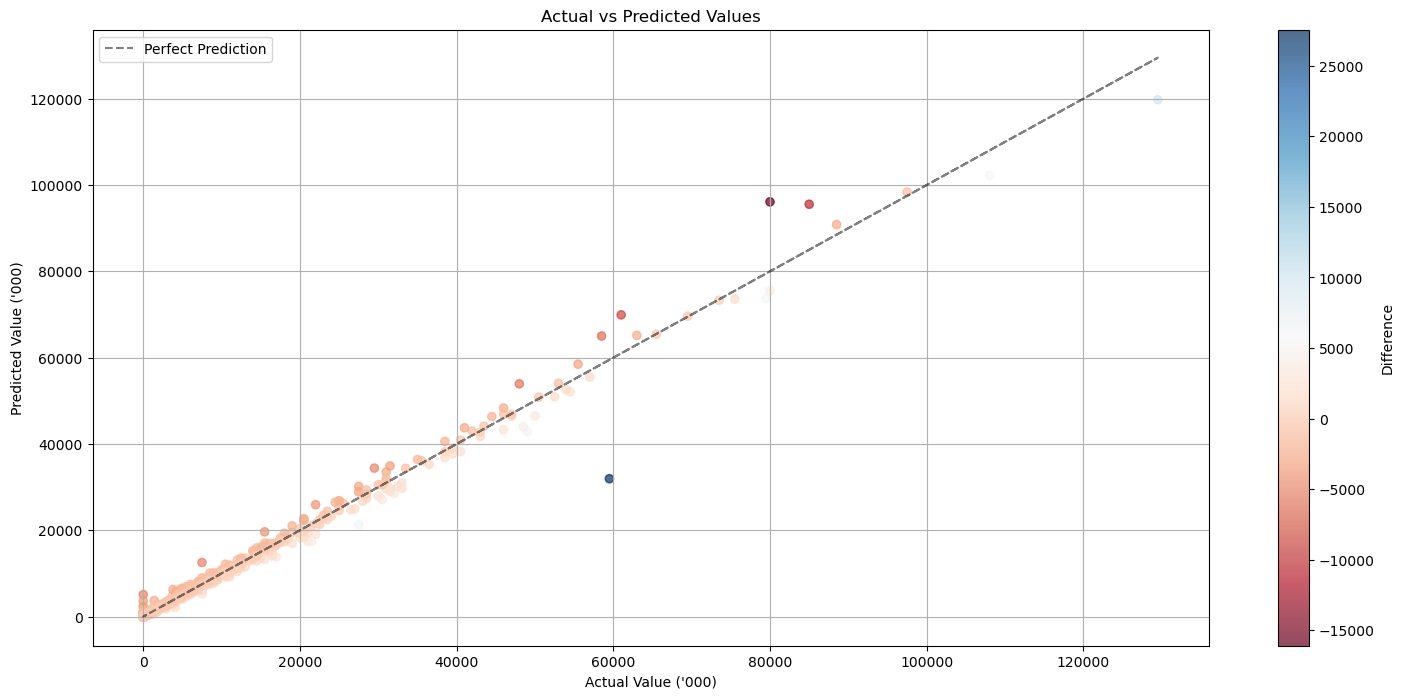

In [60]:
# Scatter plot
plt.figure(figsize=(18, 8))
plt.scatter(results_df["Value('000')"], results_df["Predicted Value"], c=results_df["Difference"], cmap='RdBu', alpha=0.7)
plt.colorbar(label='Difference')
plt.xlabel("Actual Value ('000)")
plt.ylabel("Predicted Value ('000)")
plt.title("Actual vs Predicted Values")
plt.grid(True)

# Add perfect diagonal line
plt.plot(results_df["Value('000')"], results_df["Value('000')"], color='black', linestyle='--', alpha=0.5, label='Perfect Prediction')

# Add legend
plt.legend()

plt.show()

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>8 |</span></b> <b>EVALUATE FEATURE IMPORTANCE</b></div>


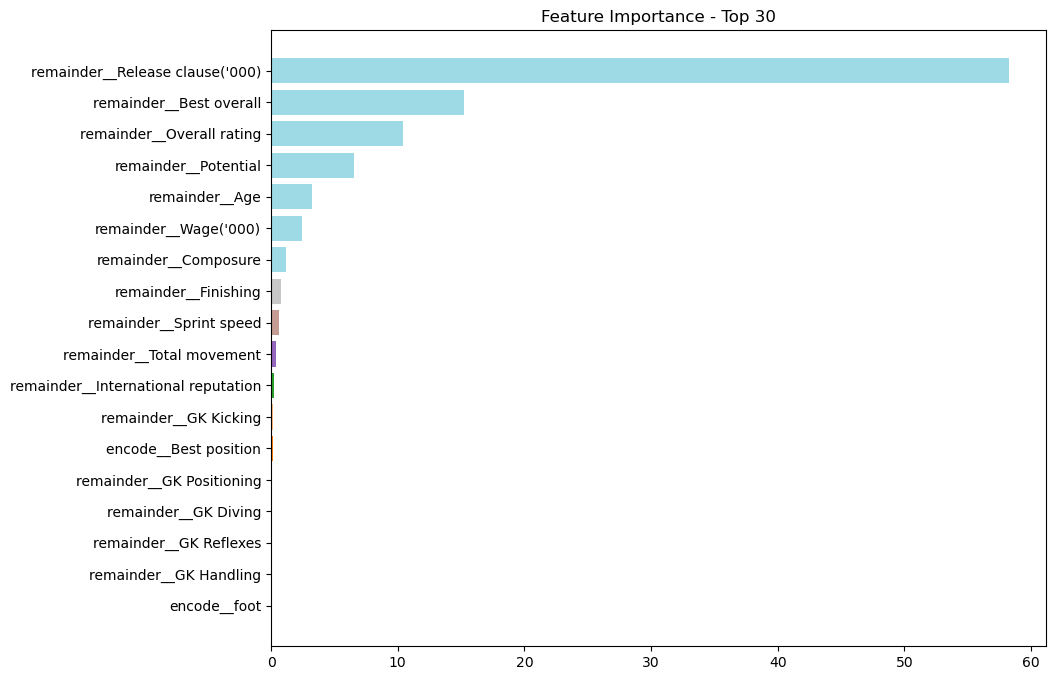

In [42]:
TOP = 30   # Define the number of top features to plot

#fir transform X
X_CB = pipeline_2.fit_transform(X)

# Initialize CatBoost regressor
catboost_reg = CatBoostRegressor(verbose=0)

# Fit the model
catboost_reg.fit(X_CB, y)

# Get feature importance
feature_importance = catboost_reg.feature_importances_

# Get the feature names from 'X'
feature_names = X_CB.columns

# Create a colormap
cmap = plt.get_cmap('tab20')

# Sort the feature importances and get the indices of the sorted array
sorted_idx = np.argsort(feature_importance)

# Plot only the top 'TOP' features
fig = plt.figure(figsize=(10, 8))
plt.barh(np.arange(len(sorted_idx))[-TOP:], feature_importance[sorted_idx][-TOP:], align='center', color=cmap(feature_importance[sorted_idx][-TOP:]))
plt.yticks(np.arange(len(sorted_idx))[-TOP:], feature_names[sorted_idx][-TOP:])
plt.title(f'Feature Importance - Top {TOP}')
plt.show()


In [43]:

# Create a SHAP explainer
explainer = shap.TreeExplainer(catboost_reg)

# Compute SHAP values
shap_values = explainer.shap_values(X_CB)


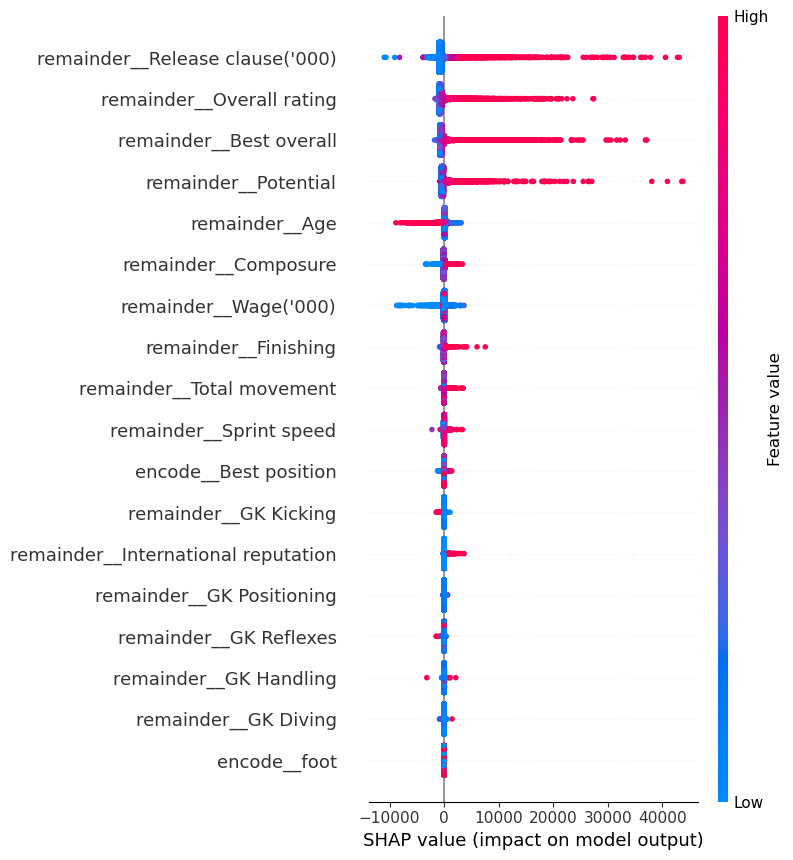

In [44]:
# Plot SHAP summary plot
shap.summary_plot(shap_values, X_CB)
